Q1 Description This notebook looks at some simple statistics of histortical intraday equity data. First we look at midprice and microprice, then order imbalance, stamped every 100 millisecond of the trading day. We will see that order imbalance tends to mean-revert, and has siginificant auto-correlation. Next, we look at the behaviour of order imbalance an instant before market order buys or sells arrive. The interesting aspect of this is that buy orders tend to arrive when the order imbalance is tilted to the buy side, while sell orders tend to arrive when the order imbalance is tilted to the sell side.

In [28]:
# import packages

import pandas as pd # for loading pandas data

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# load data

In [29]:
data = sio.loadmat(r'E:\Sem 2\High Frequency Trading\Course Work Practice Coding\AMZN_20141106.mat')

In [30]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
MO=np.array(LOB['MO'][0][0]*1.0)
dt = t[1]-t[0]

# Midprice, Microprice and Spread

In [31]:
midprice = 0.5*(bid[:,0]+ask[:,0])
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
spread = ask[:,0]-bid[:,0]

In [32]:
data = pd.DataFrame(midprice)

In [33]:
data.describe()

,0
count,234000.000000
mean,294.323667
std,0.911633
min,292.380000
25%,293.625000
50%,294.155000
75%,295.025000
max,296.855000


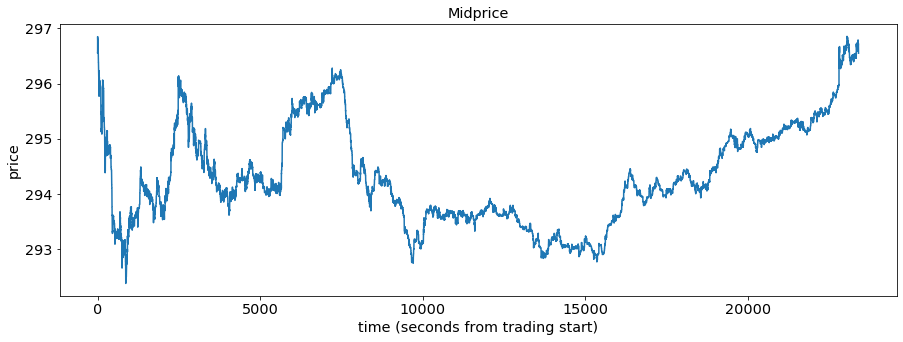

In [34]:
plt.plot(t, midprice)
plt.title('Midprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

# Ploting Microprice

In [35]:
midprice = 0.5*(bid[:,0]+ask[:,0])
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
spread = ask[:,0]-bid[:,0]

In [36]:
data = pd.DataFrame(microprice)

In [37]:
data.describe()

,0
count,234000.000000
mean,294.323601
std,0.915620
min,292.332217
25%,293.630000
50%,294.155000
75%,295.025000
max,296.931429


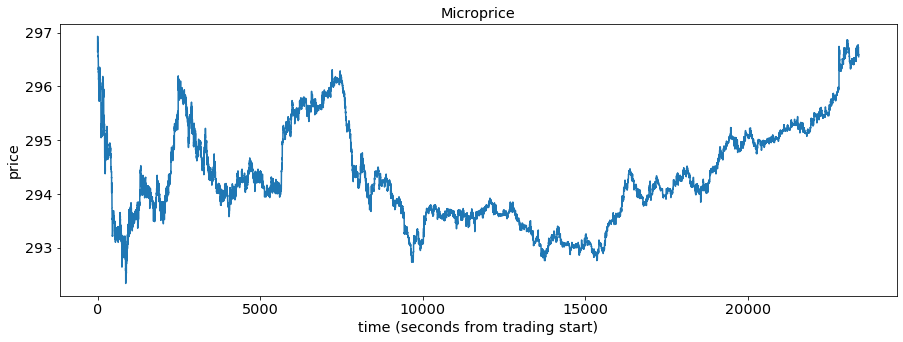

In [38]:
plt.plot(t, microprice)
plt.title('Microprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

# Plot the difference between micro and mid prices

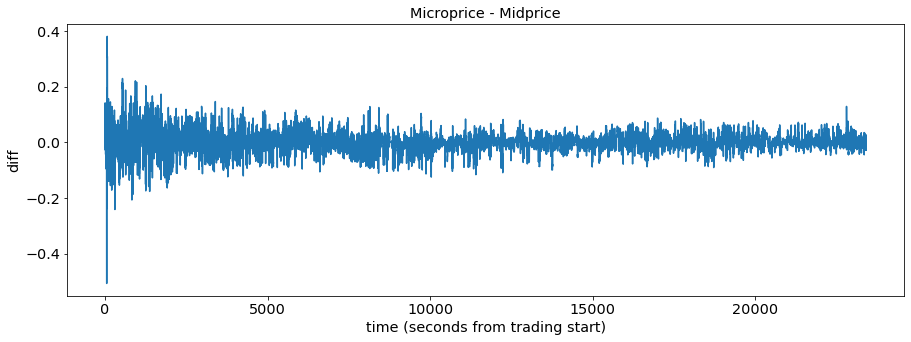

In [39]:
plt.plot(t, microprice-midprice)
plt.title('Microprice - Midprice')
plt.ylabel('diff')
plt.xlabel('time (seconds from trading start)')
plt.show()

Note that the difference is typically in the range [-0.01, 0.01] while at the beginning of the day it is three times as large.

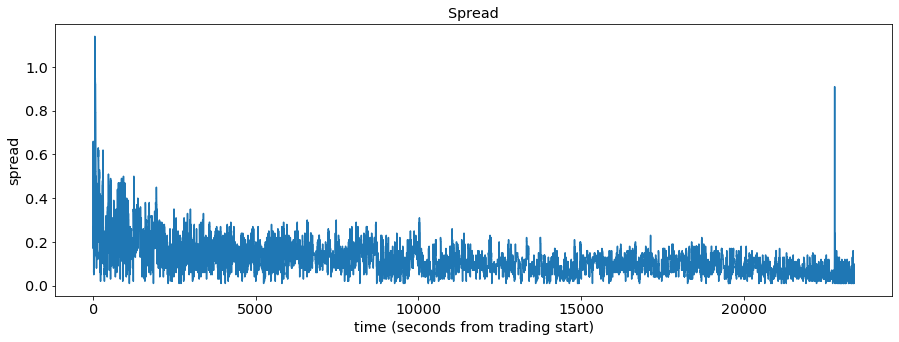

In [40]:
plt.plot(t,spread)
plt.title('Spread')
plt.ylabel('spread')
plt.xlabel('time (seconds from trading start)')
plt.show()

This plot shows that the spread is about 0.13 in the morning, but quickly drops to 0.01 but sometimes spikes to 0.02 (mostly in the morning).

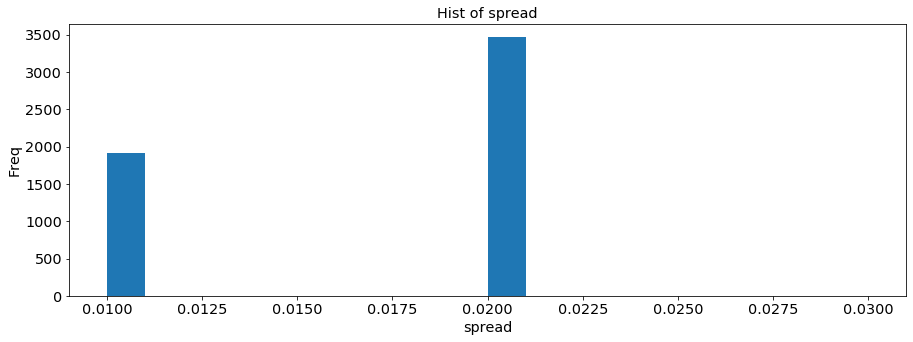

In [41]:
plt.hist(spread,bins=[0.01,0.02,0.03], width=0.001,align='mid') 
plt.title("Hist of spread")
plt.xlabel(r'spread')
plt.ylabel('Freq')
plt.show()

# Volume Imbalance

In [42]:
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

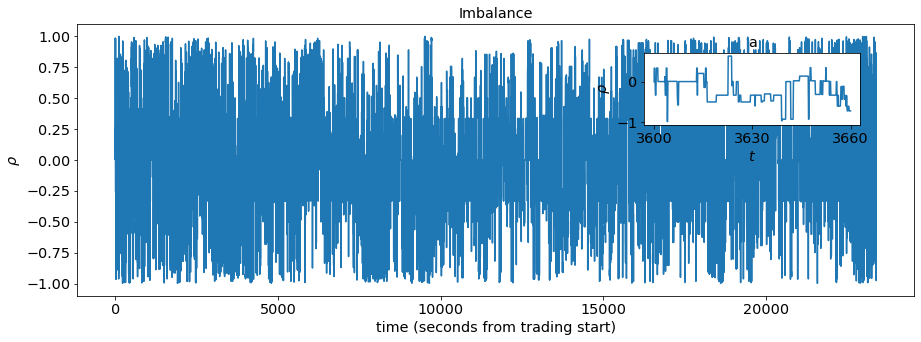

In [43]:
plt.plot(t, rho)
plt.title('Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>3600) & (t<=3600+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([3600,3630,3660])

plt.show()

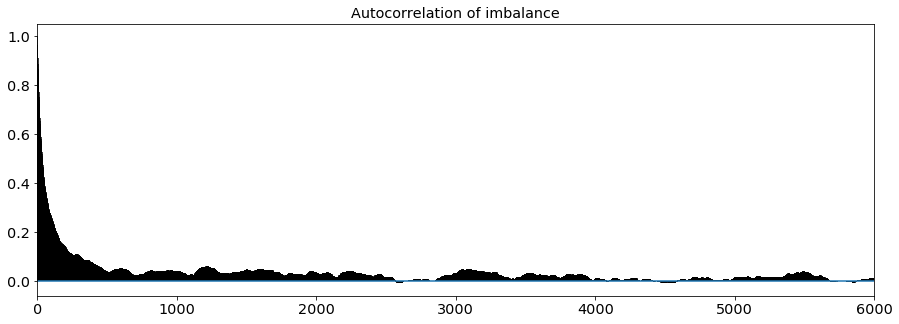

In [44]:
plt.acorr(rho[:,0]-np.mean(rho[:,0]),maxlags=6000)  # maximum one minute 
plt.title('Autocorrelation of imbalance')
plt.xlim([0,6000])
plt.show()

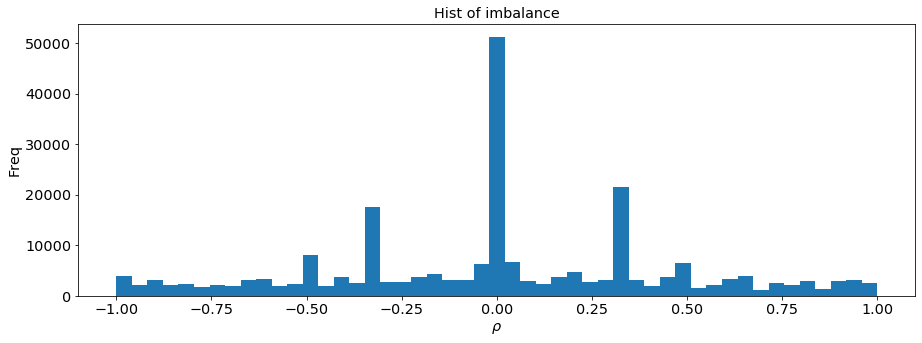

In [45]:
plt.hist(rho, bins=np.linspace(-1, 1, num=50)) 
plt.title("Hist of imbalance")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

# Volume Imbalance at times of Market Orders

In [46]:
rho_MO = (MO[:,3]-MO[:,4])/(MO[:,3]+MO[:,4])

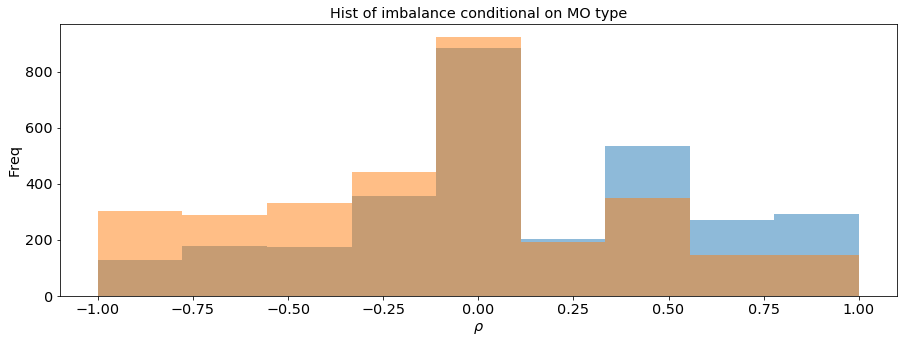

In [47]:
plt.hist(rho_MO[MO[:,7]==-1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.hist(rho_MO[MO[:,7]==+1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.title("Hist of imbalance conditional on MO type")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

# Q 2 Liquidation with Permanent Price Impact

Introduction
This notebook explores optimal execution strategies in the simpliest setting. The theory is covered in Chap 6.5 of

Algorithmic and High-Frequency Trading (c) Cartea, Jaimungal, & Penalva, 2015 Cambridge University Press

https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance/dp/1107091144/ref=cm_cr_arp_d_product_top?ie=UTF8

The agent controls their speed of trading  𝜈 , and assumes that she receives an execution price of
𝑆𝜈𝑡−𝑘𝑄𝜈𝑡
 
which is linear in her trading rate to account for the cost of walking the limit order book. Furthermore, her trading induces a drift in the asset price, which is otherwise assmed to be a Brownian motion. Hence,  𝑆𝜈𝑡  satisfies the SDE
𝑑𝑆𝜈𝑡=𝑎𝜈𝑡𝑑𝑡+𝜎𝑑𝑊𝑡
 
She aims to maximize the performance criterion
𝔼[𝑋𝜈𝑇+𝑄𝜈𝑇(𝑆𝜈𝑇−𝛼𝑄𝜈𝑇)−𝜙∫𝑇0(𝑄𝜈𝑢)2𝑑𝑢]
 
where  𝑋𝜈𝑇  is the total cash from trading, and the term  𝛼(𝑄𝜈𝑇)2  represents a penalty on holding terminal inventory (which we will send to infinity to guarantee liquidation).

# Solving DPE

As shown in the chapter, the dynamic programming principle implies that the value function satisfies the  
𝐇𝐉𝐁  equation
0=(∂𝑡+12𝜎2∂𝑆𝑆)𝐻−𝜙𝑞2+sup𝜈{(𝜈(𝑆−𝑓(𝜈))∂𝑥−𝑔(𝜈)∂𝑆−𝜈∂𝑞)𝐻}

 
subject to the terminal condition  𝐻(𝑇,𝑥,𝑆,𝑞)=𝑥+𝑆𝑞−𝛼𝑞2 .


For the case of linear impact functions  𝑓(𝜈)=𝑘𝜈  and  𝑔(𝜈)=𝑏𝜈 , the  𝐃𝐏𝐄  can be solved explicitly and the optimal speed to trade is

                   𝜈∗𝑡=𝛾𝜁𝑒𝛾(𝑇−𝑡)+𝑒−𝛾(𝑇−𝑡)/𝜁𝑒𝛾(𝑇−𝑡)−𝑒−𝛾(𝑇−𝑡)𝑄𝜈∗𝑡

 
From this equation, it is also possible to obtain the agent's inventory  𝑄𝜈∗𝑡  that results from following this strategy.

                    𝑄𝜈∗𝑡=𝜁𝑒𝛾(𝑇−𝑡)+𝑒−𝛾(𝑇−𝑡)/𝜁𝑒𝛾(𝑇−𝑡)−𝑒−𝛾(𝑇−𝑡)𝑄0.
 
The details of the derivations can be found from Page 145 to Page 147.

Now we show the implementation of the optimal speed to trade at and inventory along the optimal strategy in the following code.

In [48]:
pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [49]:
# Import necessary libraries.
import numpy as np
import import_ipynb
import Liquidation_Permanent_Price_Impact_helper as lppi_helpers

The following code computes the optimal speed to trade at  𝜈∗𝑡  and inventory along the optimal strategy  𝑄𝜈∗𝑡 .

In [50]:
# Parameter settings
T = 1
Ndt = 6.5 * 3600
dt = T / Ndt
t = np.arange(0, T + dt, dt)

k = 0.003   #temporary impact parameter
b = 0.002   #permanent price impact

tau = T - t
tt = np.arange(0, 1 + 1 / 10, 1 / 10)

myphi = np.array([10e-10, 0.001, 0.01, 0.1])
symb = np.array(["o", "*", "+", "^"])

alpha = 100

Now we use show the change of the investor's inventory along the optimal path for various levels of the running penalty  𝜙  as  𝛼  changes.

 

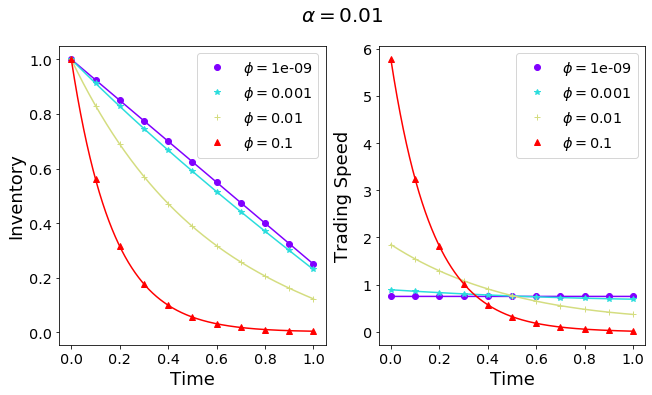

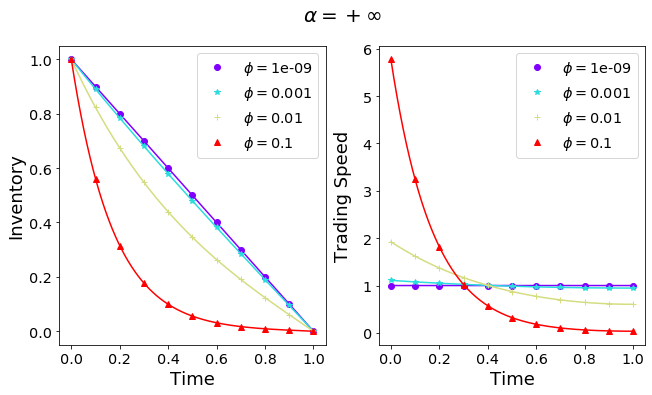

In [51]:
# Fig 6.2 of Page 148
lppi_helpers.plot_inventory_trading_speed(0.01, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = 0.01$")
lppi_helpers.plot_inventory_trading_speed(100, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = +\infty$")

# Non-Linear Temporary Price Impact

Now we assume the price impact function  𝑓(𝑣)  to be non-linear and look at its effect on the optimal strategy.

The agent's performance criteria is again
𝔼[𝑋𝜈𝑇+𝑄𝜈𝑇(𝑆𝜈𝑇−𝛼𝑄𝜈𝑇)−𝜙∫𝑇0(𝑄𝜈𝑢)2𝑑𝑢]
 
and the dynamics of  𝑆𝜈 ,  𝑋𝜈  and  𝑄𝜈  are with the explicit non-linear impact model written in place:
𝑑𝑆𝜈𝑡=−𝑏𝜈𝑡𝑑𝑡+𝜎𝑑𝑊𝑡,𝑑𝑋𝜈𝑡=(𝑆𝜈𝑡−𝑓(𝜈𝑡))𝜈𝑡𝑑𝑡,𝑑𝑄𝜈𝑡=−𝜈𝑡𝑑𝑡.
Applying  𝐃𝐏𝐏 , then, denote  𝐹(𝜈)=𝜈𝑓(𝜈) , and assuming  𝜈𝑓(𝜈)  is convex, we can write the non-linear  𝐏𝐃𝐄  for  ℎ  as
∂𝑡ℎ−𝜙𝑞2+𝐹∗(−(𝑏𝑞+∂𝑞ℎ))=0,ℎ(𝑡,𝑞)=−𝛼𝑞2
 
where  𝐹∗(𝑢)  is the Legendre-Fenchel dual of  𝐹(𝑥) . The detailed derivation can be found from Page 152 to Page 154.

As an example, for power impact model we write  𝑓(𝑥)=𝑘𝑥𝑎 , and so  𝐹(𝑥)=𝑘𝑥1+𝑎 . Then,
𝐹∗(𝑦)=sup𝑥(𝑥𝑦−𝑘𝑥1+𝑎).
 
First order condtion implies
𝑥∗=(𝑦(1+𝑎)𝑘)1𝑎,
 
and so
𝐹∗(𝑦)=𝜉𝑦1+1𝑎,𝜉=𝑎𝑘((1+𝑎)𝑘)1+1𝑎
 
and the optimal trading speed in feedback form is
𝜈∗=(−𝑏𝑞+∂𝑞ℎ(1+𝑎)𝑘)1𝑎.

Now we demonstrate the effect of non-linear impact on the optimal strategy in the case of a power law temporary impact function with power parameter  𝑎 . The model parameters are  𝑏=𝑘=10−4 ,  𝜙=10𝑘 ,  𝛼=100𝑘 , and  𝑇=1 .

In [52]:
# Parameter Settings
a = np.array([1, 0.8, 0.6])
k = 0.0001
b = 0.0001

phi = 10 * k
alpha = 100 * k
T = 1
qmax = 1

Ndt = 10000
Ndq = 100

dt = T / Ndt
dq = qmax / Ndq

The curves below are obtained by numerically solving the $\textbf{PDE}$ with a finite difference scheme, substituting the solution to the optimal trading speed in feedback form, and then numerically integrating $dQ_t^{\nu^*} = -\nu_t^*dt$, with $Q_0^{\nu^*} = 1$, to obtain $Q_t^{\nu^*}$.

In [53]:
nus, Qs, myleg, t, q = lppi_helpers.solve_pde(T, dt, qmax, dq, k, a, b, alpha, phi, Ndt, Ndq)

Plot the optimal speed to trade at vs time.

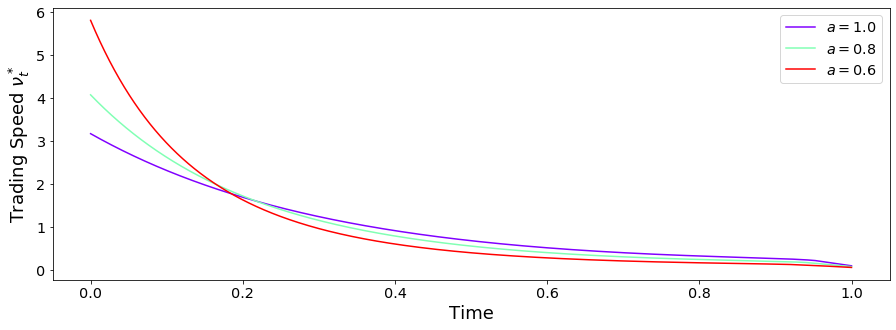

In [54]:
lppi_helpers.plot_multiple(t, nus.T, r"Time", r"Trading Speed $\nu^*_t$", None, myleg)

Plot the inventory along the optimal strategy vs time.

Fig 6.4 of Page 154
lppi_helpers.plot_multiple(t, Qs.T, r"Time", r"Inventory $Q_t^{\nu^*}$", None, myleg)